# House Prices: Advanced Regression Techniques
© Luis E Arribas - Computer science engineer

This notebook solves the House Prices: Advanced Regression Techniques challenge (kaggle). This model scored 0.11771 in public board @ kaggle, making it a top 18% result in the scoreboard.

References and previous influent models are listed below.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, KFold, cross_val_score 

#import data and inspect data shape
train_data=pd.read_csv('train.csv',index_col='Id' )
test_data=pd.read_csv('test.csv',index_col='Id' )

#Take a look on the data shape
train_data.shape, test_data.shape

((1460, 80), (1459, 79))

In [2]:
#Train and test data will be manipulated during the feature engeniering
#so a new dataframe called combined_data is created
y_train=train_data.SalePrice
X_train=train_data.drop(['SalePrice'], axis=1)

#let´s check how the results should look like... an index col clled "id" and a value col called "SalePrice"
submission = pd.read_csv("sample_submission.csv", index_col=0)
submission.head()

,SalePrice
Id,
1461,169277.052498
1462,187758.393989
1463,183583.683570
1464,179317.477511
1465,150730.079977


## 1. Data analisys and manipulation

1. Target value distribution
2. Most relevant features 
3. Outliers

### Target value distribution


In [3]:
#Plotting target column (SalePrice) distribution. Looks like there are not negative values (as expected) and 
#looks like a logarithmic distribution. We compare it with a normal distribution in the plot and test its normality.

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.title('Sale Price Distribution')
sns.distplot(y_train.values, fit=stats.norm)
print('Shapiro test: ', stats.shapiro(y_train.values))
print('Skewness test: ', stats.skew(y_train.values))

Shapiro test:  (0.869671642780304, 3.206247534576162e-33)
Skewness test:  1.880940746034036


Shapiro test:  (0.9912067651748657, 1.1490678986092462e-07)
Skewness test:  0.1212103673013655


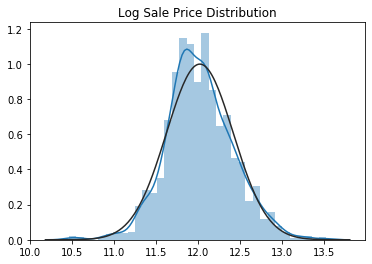

In [4]:
#Lets apply log function to target value. Regression models works much better in normal dists
y_train=np.log(y_train)
plt.title('Log Sale Price Distribution')
sns.distplot(y_train.values, fit=stats.norm)
print('Shapiro test: ', stats.shapiro(y_train.values))
print('Skewness test: ', stats.skew(y_train.values))


###  Target correlated features

In [5]:
#Check correlation amongst features
target_corr=pd.concat([X_train, y_train], axis=1).corr()
target_corr=target_corr['SalePrice']

#Transform negative corr to pos
target_corr.loc[target_corr <0]=target_corr.loc[target_corr <0]*(-1)
target_corr=target_corr.sort_values(ascending=False)

#Select corr values greater than arbitrary value 0.6
target_corr=target_corr.loc[target_corr>0.6]
target_corr

SalePrice      1.000000
OverallQual    0.817184
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
TotalBsmtSF    0.612134
Name: SalePrice, dtype: float64

### Outliers

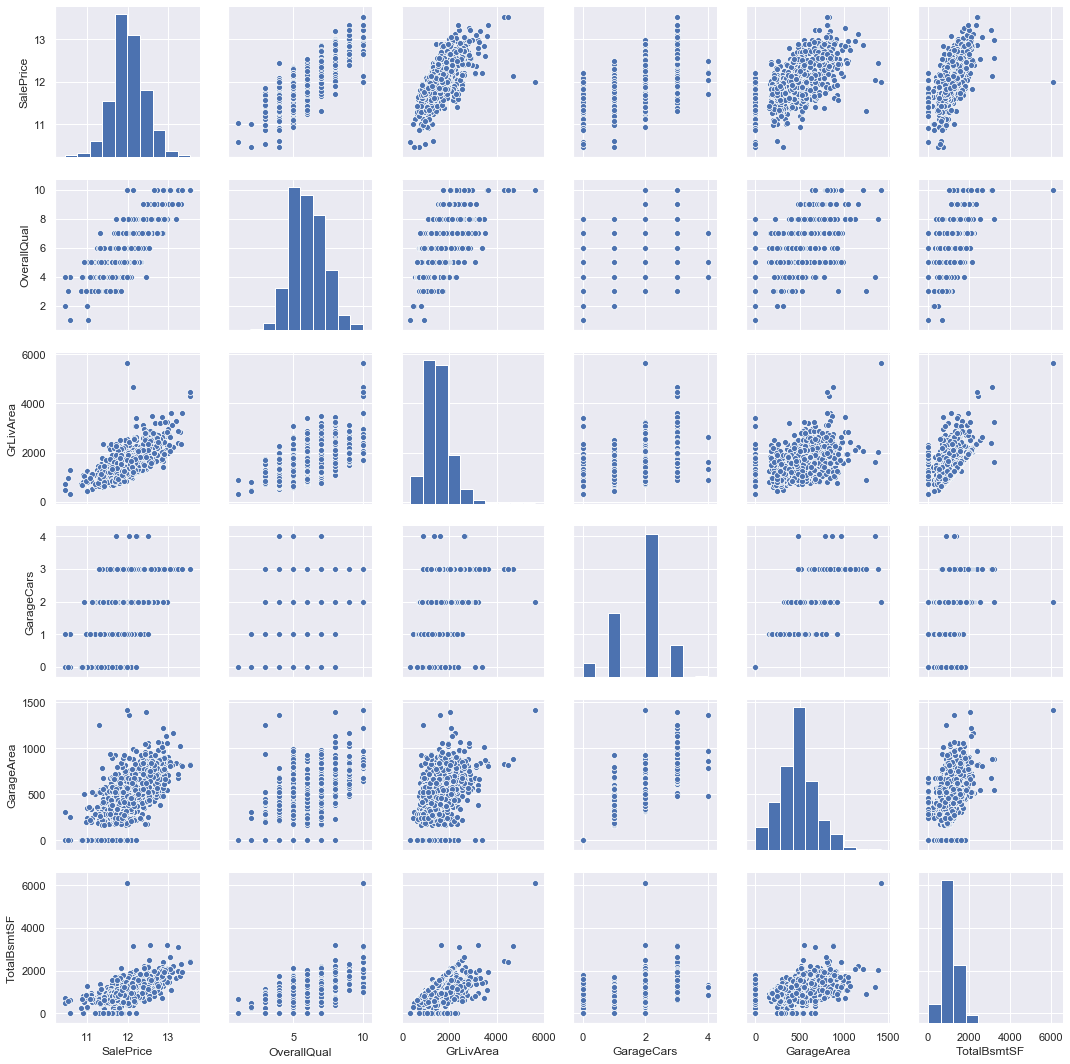

In [6]:
#scatterplot shows samples out of the middle angle line
sns.set()
cols = target_corr.index
train_data=pd.concat([X_train,y_train], axis=1)
sns.pairplot(train_data[cols], height = 2.5)
plt.show();

In [7]:
#Delete outliers
train_data=train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']>100000)].index)
train_data=train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<130000)].index)
train_data=train_data.drop(train_data[(train_data['GarageArea']>1100) & (train_data['SalePrice']<125000)].index)
train_data.shape

(1450, 80)

## 2. Feature engeniering

1. Missing data
2. Transform non numerical data types
3. Closing data to normal distribution  

In [8]:
#Combine test and train X data in order to do feat engeniering
y_train=train_data.SalePrice
X_train=train_data.drop(['SalePrice'], axis=1)
combined_data=X_train.append(test_data)
combined_data.shape

(2909, 79)

### Missing data

Nan is used to express values in some columns (see data description), so lets check them separately:

The following columns missing values will be imputed as 'None' 

- Alley: NA 	No alley access

- Fireplace:  NA	No Fireplace

- GarageType, GarageFinish, GarageQual, GarageCond: NA	No Garage

- PoolQC: NA	No Pool

- Fence: Fence quality  NA	No Fence

- MiscFeature NA	None


For LotFrontage we´ll impute the mean of the Neighborhood values.


GarageYrBlt is imputed with the year of building of the house

We´ll drop the columns wich are useless, since they are not giving representative information, due there is not enought variance in its distribution to be stistically significative. Because of that, we´ll drop those columns in which one value is bigger than 90% samples. This is an arbitrarely threshold, so we could try with different values.

Dropped out dropped out :

 - Street
 - Alley
 - Utilities
 - LandSlope
 - Condition2
 - RoofMatl
 - Heating
 - CentralAir
 - Electrical
 - Functional
 - GarageCond
 - PavedDrive
 - PoolQC
 - MiscFeature



In [9]:
#Count null values by columns
any_nan_col=combined_data.isna().sum().sort_values(ascending= False)
any_nan_col.loc[any_nan_col.values>0]


PoolQC          2901
MiscFeature     2805
Alley           2711
Fence           2339
FireplaceQu     1419
LotFrontage      485
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

In [10]:
#The following columns missing values will be imputed as 'None'
cols=['Alley','FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
      'GarageCond', 'PoolQC', 'Fence', 'MiscFeature' ]
combined_data[cols]=combined_data[cols].fillna('None')    
combined_data[cols].isna().sum()

Alley           0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [11]:
#Remaining columns with null values
any_nan_col=combined_data.isna().sum().sort_values(ascending= False)
any_nan_col.loc[any_nan_col.values>0]

LotFrontage     485
GarageYrBlt     159
BsmtExposure     82
BsmtCond         82
BsmtQual         81
BsmtFinType2     80
BsmtFinType1     79
MasVnrType       24
MasVnrArea       23
MSZoning          4
Functional        2
Utilities         2
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
KitchenQual       1
GarageCars        1
Exterior2nd       1
Exterior1st       1
Electrical        1
SaleType          1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64

In [12]:
#LotFrontage: imputing the mean of the Neighborhood values
combined_data["LotFrontage"] = combined_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

#GarageYrBlt is imputed with the year of building of the house
combined_data["GarageYrBlt"] = combined_data["GarageYrBlt"].transform(lambda x: x.fillna(combined_data['YearBuilt']))

#Select object columns. We´ll drop those wich are useless as they are not giving representative information
col=combined_data.dtypes=='object'
col=col.loc[col.values==True]

#So, we drop those columns in which one value is bigger than 90% samples
droped_c=[]
for c in col.index:
    percs=combined_data[c].value_counts().values/len(combined_data)
    if len(percs[percs>0.9]):
        combined_data=combined_data.drop(c, axis=1)
        droped_c.append(c)

#Lets see what columns have we dropped out      
droped_c

['Street',
 'Alley',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'MiscFeature']

In [13]:
#Lets see how it is going. The following columns still got null values
any_nan_col=combined_data.isna().sum().sort_values(ascending= False)
any_nan_col.loc[any_nan_col.values>0]


BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
MasVnrType      24
MasVnrArea      23
MSZoning         4
BsmtFullBath     2
BsmtHalfBath     2
KitchenQual      1
Exterior1st      1
SaleType         1
TotalBsmtSF      1
BsmtUnfSF        1
BsmtFinSF2       1
Exterior2nd      1
BsmtFinSF1       1
GarageCars       1
GarageArea       1
dtype: int64

In [14]:
#From here, we´ll use 4 diferent policies for the remaing columns:

#If categorical then none
for c in ['BsmtExposure','BsmtCond','BsmtQual', 'BsmtFinType1','BsmtFinType2']:
    combined_data[c]=combined_data[c].fillna('None')

#If numerical then 0
for c in ['BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2',
          'GarageCars','GarageArea','BsmtUnfSF','MasVnrArea']:
    combined_data[c]=combined_data[c].fillna(0)
    
#For numeric codes we use the neigborhood mede
for c in ['KitchenQual', 'Exterior1st', 'SaleType','BsmtFinType2','Exterior2nd']:
    combined_data[c]=combined_data[c].transform(
        lambda x: x.fillna(combined_data[c].mode()[0]))
    
#Some codes with Unknown
for c in ['MasVnrType', 'MSZoning']:
    combined_data[c]=combined_data[c].fillna('Unknown')

#Lets check that there are no null data in df
print(combined_data.isna().sum().sum())


0


### Transform non numerical data types

For categories we´ll use a numerical labeling, for no categorical object data type we´ll apply a hot encoding policy. 


In [15]:
#For categories we´ll use a numerical labeling
for c in ['BsmtQual', 'BsmtCond','HeatingQC', 'KitchenQual', 
          'FireplaceQu', 'GarageQual', 'ExterQual', 'ExterCond']:
    codes={c:{'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}}
    combined_data.replace(codes, inplace=True)
    combined_data[c]=combined_data[c].astype('category')

#So we do for Fence 
codes={'Fence':{'Na':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}}
combined_data.replace(codes, inplace=True)
combined_data['Fence']=combined_data[c].astype('category')

In [16]:
#Transform dtypes to int8 (just to save resources)
for c in ['BsmtQual', 'BsmtCond','HeatingQC', 'KitchenQual', 
          'FireplaceQu', 'GarageQual', 'ExterQual', 'ExterCond']:
        combined_data[c]=combined_data[c].astype('int8')

#Cheking data types. Selecting object columns. 
combined_data.dtypes.loc[combined_data.dtypes=='object']

MSZoning         object
LotShape         object
LandContour      object
LotConfig        object
Neighborhood     object
Condition1       object
BldgType         object
HouseStyle       object
RoofStyle        object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
Foundation       object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
GarageType       object
GarageFinish     object
SaleType         object
SaleCondition    object
dtype: object

In [17]:
#Lets do some Hot encoding
combined_data=pd.get_dummies(combined_data)
combined_data.shape

(2909, 208)

### Some extra feat enginiering
We try transforming the float type most correlated features. Lets see if its possible to make them more suitable for prediction models trying to make them more normal. We´ll use a log operation.

0
0
(0.9513072371482849, 4.558408353731696e-30)


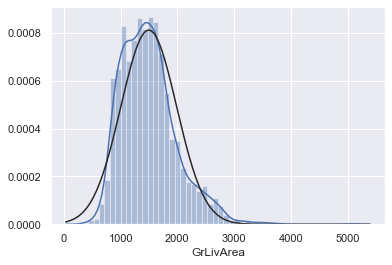

In [18]:
#Overall GrLivArea distribution
#Looks like a log distribution in the plot before.
print(combined_data['GrLivArea'].isna().sum())
print(len(combined_data['GrLivArea'].loc[combined_data['GrLivArea']==0]))
print(stats.shapiro(combined_data['GrLivArea']))
sns.distplot(combined_data['GrLivArea'], fit=stats.norm)


Shapiro test:  (0.9972575902938843, 4.49444523837883e-05)
Skewness test:  -0.04242409191410022


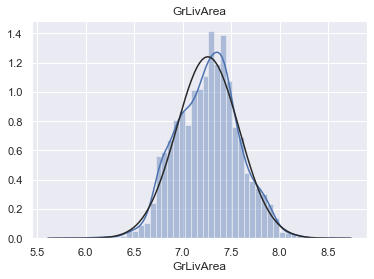

In [19]:
#Looks like a log distribution. Compare it with a normal dist
from scipy import stats

combined_data['GrLivArea']=np.log1p(combined_data['GrLivArea'])

#Check results
plt.title('GrLivArea')
sns.distplot(combined_data['GrLivArea'], fit=stats.norm)
print('Shapiro test: ', stats.shapiro(combined_data['GrLivArea'].values))
print('Skewness test: ', stats.skew(combined_data['GrLivArea'].values))
#Ok, Skewness improves, so it might be a good idea ^_^

0
158
Normality test: (0.9785208702087402, 1.4561790900960068e-20)
Skewness test: 0.14209357703541042


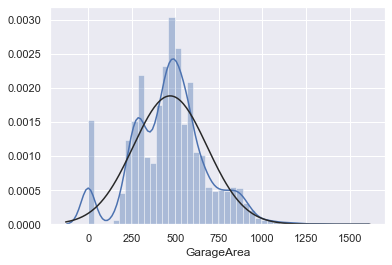

In [20]:
#Lets take a look on GarageArea:
#Looks like a log distribution?. Not really :(
print(combined_data['GarageArea'].isna().sum())
print(len(combined_data['GarageArea'].loc[combined_data['GarageArea']==0]))
print('Normality test:', stats.shapiro(combined_data['GarageArea']))
print('Skewness test:', stats.skew(combined_data['GarageArea']))
sns.distplot(combined_data['GarageArea'], fit=stats.norm)

0
0
Normality test: (0.9624173641204834, 7.475116515382045e-27)
Skewness test: 0.6597488340451918


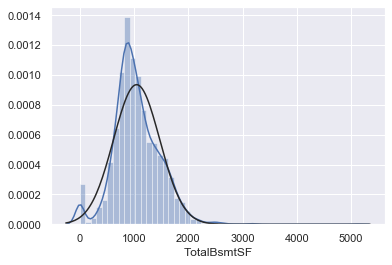

In [21]:
#Overall value distribution
#Looks like a log distribution?.
#Regresion models usaully work beter with normal dist, so lest see if sapiro test improves its result applying log ops 
print(combined_data['TotalBsmtSF'].isna().sum())
print(len(combined_data['TotalBsmtSF'].loc[combined_data['TotalBsmtSF']==1]))
print('Normality test:', stats.shapiro(combined_data['TotalBsmtSF']))
print('Skewness test:', stats.skew(combined_data['TotalBsmtSF']))
sns.distplot(combined_data['TotalBsmtSF'], fit=stats.norm)

Shapiro test: (0.928546667098999, 3.510233909365408e-35)
Skew test: 0.4852229448406848


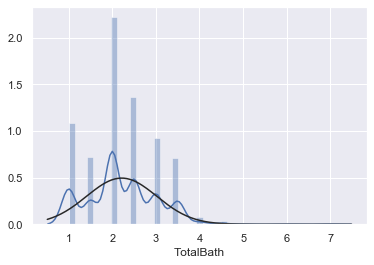

In [22]:
#Add new feature total baths
combined_data['TotalBath']=(combined_data['BsmtFullBath']+combined_data['BsmtHalfBath']*0.5+combined_data['FullBath']+combined_data['HalfBath']*0.5)
sns.distplot(combined_data['TotalBath'], fit=stats.norm)
print('Shapiro test:', stats.shapiro(combined_data['TotalBath']))
print('Skew test:', stats.skew(combined_data['TotalBath']))

In [23]:
#Take a look on data before model building
combined_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalBath
count,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,...,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000
mean,57.148505,69.761509,10114.574424,6.081815,5.566861,1971.238570,1984.222757,100.112754,3.393606,3.085596,...,0.080096,0.002406,0.867308,0.064971,0.004125,0.008250,0.015813,0.824682,0.082159,2.215194
std,42.493918,21.125935,7797.531095,1.399367,1.113912,30.285144,20.889913,176.191640,0.575856,0.372585,...,0.271489,0.049004,0.339299,0.246517,0.064106,0.090471,0.124773,0.380304,0.274654,0.805605
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,20.000000,60.000000,7450.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.500000
50%,50.000000,70.000000,9434.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,70.000000,80.000000,11512.000000,7.000000,6.000000,2001.000000,2004.000000,162.000000,4.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.500000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


## Regression models

1. Scaling data

2. Regression models solo performance - best of breed selection 

3. Hyperparameter Randomized search 

3. Ensemble data - Stacking


### Scaling data


In [24]:
#Scaling dataframe with RobustScaler, which is better for the outlayers
from sklearn import preprocessing

transformer = preprocessing.RobustScaler().fit(combined_data)
normalized_X = transformer.transform(combined_data)
X_train=normalized_X[0:len(y_train),]
X_test=normalized_X[len(y_train):len(normalized_X)]
print(normalized_X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(2909, 209)
(1450, 209)
(1459, 209)
(1450,)


In [25]:
#Cross validation implementation for private tests
#with the data remaining rows

def rmsle_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Regression models solo performance - best of breed selection

Lets try the following regresion algorithms over our train data and check their performance by CV.

- Elastic Net
- RandomForest reegrsssor
- Kernel ridge regressor
- xgboost
- Lasso
- SVR

In [26]:
#Elastic Net
from sklearn.linear_model import ElasticNet
enet_reg=ElasticNet(alpha=0.0005)
enet_reg.fit(X_train, y_train)
print (rmsle_cv(enet_reg).mean())

0.11332437432254158


In [27]:
from sklearn.ensemble import RandomForestRegressor
rf_reg=RandomForestRegressor()
rf_reg.fit(X_train, y_train)
print (rmsle_cv(rf_reg).mean())

/Users/luisarribas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.1448762754047525


In [28]:
from sklearn.kernel_ridge import KernelRidge
kr_reg=KernelRidge(alpha=0.0005)
kr_reg.fit(X_train, y_train)
kr_pred=kr_reg.predict(X_test)
print (rmsle_cv(kr_reg).mean())

0.15634686005247084


In [29]:
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
xgb_reg = xgb.XGBRegressor(alpha=0.0005)
xgb_reg.fit(X_train, y_train)
print(rmsle_cv(xgb_reg).mean())

[07:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.12280231490065321


In [30]:
from sklearn.linear_model import Lasso

lasso_reg =  Lasso(alpha=0.0005)
lasso_reg.fit(X_train, y_train)
print (rmsle_cv(lasso_reg).mean())

0.11259527348829237


In [31]:
from sklearn.svm import SVR
svr_reg = SVR()
svr_reg.fit(X_train, y_train)
print (rmsle_cv(svr_reg).mean())

0.21034178853035992


### Models hyperparameter Randomized search.
### (Skip exec: You better run hyperparams fitted code)

Now let´s find the best hyperparameters for each model. Based over the performances seen for the diferent algorithms we´ll combine xgboost, lasso, gradientboosting and elastic net in a stack, where SVR will be the meta-model. 

In [32]:
# ElasticNet model hyperparameter search
params = {
    'alpha': [0.0005, 0.0006, 0.0007],
    'l1_ratio': [ 0.3, 0.5, 0.7],
    'fit_intercept': [True, False],
    'normalize': [False],
    'precompute': [True],
    'warm_start': [True, False],
    'random_state': [13],
    'selection': ['random', 'cyclic']
    }
enet_reg = ElasticNet()
clf = RandomizedSearchCV(enet_reg, params, verbose=0)
clf.fit(X_train,y_train)
enet_reg = ElasticNet(**clf.best_params_)
print('Best parameters:{}'.format(clf.best_params_))
enet_reg.fit(X_train, y_train)
print(rmsle_cv(enet_reg).mean())

Best parameters:{'warm_start': False, 'selection': 'cyclic', 'random_state': 13, 'precompute': True, 'normalize': False, 'l1_ratio': 0.5, 'fit_intercept': True, 'alpha': 0.0005}
0.1133243743225418


In [33]:
# XGBRegressor model hyperparameter search

import warnings
warnings.filterwarnings("ignore")

params = {
    'colsample_bytree': [0.2, 0.4, 0.7],
    'gamma': [0.0],
    'learning_rate': [0.05, 0.005, 0.0075, 0.01],
    'max_depth': [2, 3, 6, 9],
    'min_child_weight': [0, 4],
    'n_estimators': [3000],
    'seed': [1],
    'subsample': [0.1, 0.2, 0.4],
    'objective':['reg:squarederror'],
    'reg_alpha':[0.00006],
    'cale_pos_weight':[1],
    'verbosity':[0]
    }

xgb_reg = xgb.XGBRegressor()
clf = RandomizedSearchCV(xgb_reg, params, verbose=0)
clf.fit(X_train,y_train)
xgb_reg = xgb.XGBRegressor(**clf.best_params_)
print('Best parameters:{}'.format(clf.best_params_))
xgb_reg.fit(X_train, y_train)
print(rmsle_cv(xgb_reg).mean())

Best parameters:{'verbosity': 0, 'subsample': 0.2, 'seed': 1, 'reg_alpha': 6e-05, 'objective': 'reg:squarederror', 'n_estimators': 3000, 'min_child_weight': 0, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.2, 'cale_pos_weight': 1}
0.11284928675923023


In [34]:
#Lasso model hyperparameter search

from sklearn.linear_model import Lasso

params= {'alpha' : [0.0005, 0.0006, 0.0007], 
        'copy_X' : [False],
        'fit_intercept' : [True, False],
        'max_iter' :[4000, 6000],
        'normalize' :[True, False],
        'positive' :[True, False],
        'precompute' :[True, False],
        'random_state' : [32],
        'selection' :['cyclic', 'random'],
        'tol' :[0.0001, 0.001, 0.01],
        'warm_start' :[True, False]}

lasso_reg =  Lasso()
clf = RandomizedSearchCV(xgb_reg, params, verbose=0)
clf.fit(X_train, y_train)
lasso_reg=Lasso(**clf.best_params_)
print(f'Best parameters:{clf.best_params_}')
lasso_reg.fit(X_train, y_train)
print (rmsle_cv(lasso_reg).mean())

Best parameters:{'warm_start': True, 'tol': 0.01, 'selection': 'random', 'random_state': 32, 'precompute': True, 'positive': False, 'normalize': False, 'max_iter': 6000, 'fit_intercept': False, 'copy_X': False, 'alpha': 0.005}
0.38718445453080835


In [35]:
#GradientBoostingRegressor model hyperparameter search

from sklearn.ensemble import GradientBoostingRegressor

params = {'loss':['ls'],
          'learning_rate':[0.01,0.1, 0.5],
          'n_estimators':[300, 1000, 3000],
          'subsample': [0.3, 0.7, 1.0],
          'criterion':['friedman_mse'],
          'min_samples_split':[2, 3, 4],
          'min_samples_leaf':[1,2],
          'min_weight_fraction_leaf':[0.0],
          'max_depth':[3, 4, 6],
          'min_impurity_decrease':[0.0,0.1,0.2],
          'min_impurity_split':[None],
          'init':[None],
          'random_state':[13],
          'max_features':['auto'],
          'alpha':[0.9],
          'verbose': [0],
          'max_leaf_nodes':[None], 
          'warm_start': [False],
          'presort':['auto'],
          'validation_fraction':[0.1],
          'n_iter_no_change': [None],
          'tol':[0.0001]}

gbr_reg =  GradientBoostingRegressor()
clf = RandomizedSearchCV(gbr_reg, params, verbose=0)
clf.fit(X_train, y_train)
gbr_reg=GradientBoostingRegressor(**clf.best_params_)
print(f'Best parameters:{clf.best_params_}')
gbr_reg.fit(X_train, y_train)
print (rmsle_cv(gbr_reg).mean())

Best parameters:{'warm_start': False, 'verbose': 0, 'validation_fraction': 0.1, 'tol': 0.0001, 'subsample': 0.7, 'random_state': 13, 'presort': 'auto', 'n_iter_no_change': None, 'n_estimators': 3000, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 1, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 6, 'loss': 'ls', 'learning_rate': 0.01, 'init': None, 'criterion': 'friedman_mse', 'alpha': 0.9}
0.1190268819122633


In [36]:
#Random Forest model hyperparameter search

from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators':[10, 20, 30],
          'max_depth':[None, 3, 5],
          'min_samples_split':[2, 3, 4],
          'min_samples_leaf': [1, 2, 4],
          'max_features':['auto', 'log2', 'sqrt'],
          'oob_score':[True, False],  
          'random_state':[39]
         }

rf_reg =  RandomForestRegressor()
clf = RandomizedSearchCV(rf_reg, params, verbose=0)
clf.fit(X_train, y_train)
rf_reg=RandomForestRegressor(**clf.best_params_)
print(f'Best parameters:{clf.best_params_}')
rf_reg.fit(X_train, y_train)
print (rmsle_cv(rf_reg).mean())

Best parameters:{'random_state': 39, 'oob_score': True, 'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
0.140813543612926


In [ ]:
#SVR model hyperparameter search
from sklearn.svm import SVR

params = {'kernel':['poly', 'rbf', 'sigmoid'],
          'degree':[3, 5, 7],
          'coef0': [1, 2, 4],
          'tol':[ 0.001, 0.005, 0.0005],  
          'epsilon':[0.05, 0.1, 0.2, 0.5]
         }

svr_reg =  SVR()
clf = RandomizedSearchCV(svr_reg, params, verbose=0)
clf.fit(X_train, y_train)
svr_reg=SVR(**clf.best_params_)
print(f'Best parameters:{clf.best_params_}')
svr_reg.fit(X_train, y_train)
print (rmsle_cv(svr_reg).mean())

In [37]:
#Kernel ridge regressor model best hyperparameters
params = {'alpha':[0.0005, 0.0003, 0.0007],
          'kernel':['linear'],
          'gamma': [None, 'RBF', 'laplacian', 'polynomial'],
          'degree':[ 3, 4, 5]           
         }

kr_reg = KernelRidge()
clf = RandomizedSearchCV(kr_reg, params, verbose=0)
clf.fit(X_train, y_train)
kr_reg=KernelRidge(**clf.best_params_)
print(f'Best parameters:{clf.best_params_}')
kr_reg.fit(X_train, y_train)
print (rmsle_cv(kr_reg).mean())

Best parameters:{'kernel': 'linear', 'gamma': 'polynomial', 'degree': 3, 'alpha': 0.0007}
0.15634331281676514


### Hyperparams fitted code
### (Run this block if you want to skip hyperparameter search)

In [32]:
#Run this chunk instead randomserarchCV one in order to avoid time waisting while restarting the kernel
# 0.11259527348829237

from sklearn.linear_model import Lasso

best_parameters={'warm_start': False, 
                 'tol': 0.001, 
                 'selection': 'cyclic', 
                 'random_state': 32, 
                 'precompute': True, 
                 'positive': True, 
                 'normalize': False, 
                 'max_iter': 4000, 
                 'fit_intercept': True, 
                 'copy_X': False, 
                 'alpha': 0.005}

lasso_reg =  Lasso(**best_parameters)
lasso_reg.fit(X_train, y_train)
print (rmsle_cv(lasso_reg).mean())

0.1256448848693999


In [33]:
#Run this chunk instead randomserarchCV one in order to avoid time waisting while restarting the kernel

from sklearn.ensemble import GradientBoostingRegressor
best_parameters={'warm_start': False, 
                 'verbose': 0, 
                 'validation_fraction': 0.1,
                 'tol': 0.0001, 
                 'subsample': 0.7,
                 'random_state': 13, 
                 'presort': 'auto', 
                 'n_iter_no_change': None, 
                 'n_estimators': 3000, 
                 'min_weight_fraction_leaf': 0.0, 
                 'min_samples_split': 2, 
                 'min_samples_leaf': 2, 
                 'min_impurity_split': None,
                 'min_impurity_decrease': 0.0, 
                 'max_leaf_nodes': None, 
                 'max_features': 'auto', 
                 'max_depth': 4, 
                 'loss': 'ls', 
                 'learning_rate': 0.1, 
                 'init': None, 
                 'criterion': 'friedman_mse',
                 'alpha': 0.9}

gbr_reg=GradientBoostingRegressor(**best_parameters)
gbr_reg.fit(X_train, y_train)
print(rmsle_cv(gbr_reg).mean())

0.11860578860797935


In [34]:
#Run this chunk instead randomserarchCV one in order to avoid time waisting while restarting the kernel
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

#Best params choosen by randomserarchCV.
best_parameters={'verbosity': 0, 
                 'subsample': 0.2, 
                 'seed': 1, 'reg_alpha': 6e-05, 
                 'objective': 'reg:squarederror', 
                 'n_estimators': 3000, 
                 'min_child_weight': 0, 
                 'max_depth': 9, 
                 'learning_rate': 0.005, 
                 'gamma': 0.0, 
                 'colsample_bytree': 0.4, 
                 'cale_pos_weight': 1}
xgb_reg = xgb.XGBRegressor(**best_parameters)
xgb_reg.fit(X_train, y_train)
print(rmsle_cv(xgb_reg).mean())

0.11332477647470936


### Stacking models

In [46]:
#Stacking with metamodel.
#Base models: Lasso, ridge, gbr, xgb ->MEta model: enet
#Version 1.1
#hay q pasarle los clasificadores ya entrenados
from sklearn.linear_model import ElasticNet
from vecstack import stacking


models=[xgb_reg, lasso_reg, gbr_reg, enet_reg]

S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric= mean_squared_error, # metric: callable
                           n_folds=5,                  # number of folds
                           shuffle=True,               # shuffle the data
                           random_state=2,             # ensure reproducibility
                           verbose = 2)                # print all info

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [XGBRegressor]


KeyboardInterrupt: 

In [43]:
#0.11057372162904007
# Initialize 2nd level model


#meta_model = xgb.XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
#                    n_estimators=3000, max_depth=3)
#meta_model = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
meta_model = SVR(gamma='scale', C=1.0, epsilon=0.2) 
#meta_model = rf_reg =  RandomForestRegressor(n_estimators=200)
# Fit 2nd level model
meta_model = meta_model.fit(S_train, y_train)

# Predict
pred = meta_model.predict(S_test)

# Final prediction score
rmse= np.sqrt(-cross_val_score(meta_model, S_train, y_train, scoring="neg_mean_squared_error", cv = 5)).mean()
print(f'Stacked regression model CV score:{rmse}') 


Stacked regression model CV score:0.11781539815774664


In [44]:
#Submision
def make_submission():
    submission=pd.DataFrame(pred)
    submission.index=test_data.index
    submission=submission.rename(columns = {0:'SalePrice'})
    #reverse log
    submission.SalePrice = np.exp(submission.SalePrice) - 1
    submission.to_csv("submission.csv", index=True)
    return submission.head()

In [45]:
make_submission()

,SalePrice
Id,
1461,116406.793788
1462,149276.456944
1463,176713.728587
1464,194375.592364
1465,188130.991057


References:

- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

- https://www.kaggle.com/redaabdou/house-prices-solution-data-cleaning-ml